In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

Here is a link to [lqrpols.py](http://www.argmin.net/code/lqrpols.py)


In [2]:
np.random.seed(1337)

# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0.0,0.01,1.01]])
B = np.eye(3)
d,p = B.shape

# LQR quadratic cost per state
Q = np.eye(3)

# initial condition for system
x0 = np.random.randn(3,1)

R = 1000*np.eye(3)

# number of time steps to simulate
T = 100

# amount of Gaussian noise in dynamics
eq_err = 1.0

In [3]:
# N_vals = np.floor(np.linspace(1,75,num=7)).astype(int)
N_vals = [5,10,20,30,40,50]
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))

# cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = lqrpols.cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = lqrpols.cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))

# model for nominal control with 1 rollout
A_nom1,B_nom1 = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)
print(A_nom1)
print(B_nom1)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom1,B_nom1)
K_nom1 = -lqrpols.lqr_gain(A_nom1,B_nom1,Q,R)
one_rollout_cost_inf = lqrpols.cost_inf_K(A,B,Q,R,K_nom1)

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model, N x 40 to match sample budget of policy gradient
        A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*8,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqrpols.lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_nom)
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_nom)

        # policy gradient, batchsize 8 per iteration
        K_pg = lqrpols.policy_gradient_adam_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N],T,
                                                          explore_mag = 0.1, step_size = 0.01)
        J_finite_pg[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_pg)
        J_inf_pg[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_pg)
        
        # random search, batchsize 4, so uses 8 rollouts per iteration
        K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N],T,
                                                   explore_mag = 0.02, step_size = 0.0025)
        J_finite_rs[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)
        J_inf_rs[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_rs)

[[ 1.0060899   0.02890157 -0.04003236]
 [ 0.01811646  0.977807    0.01502689]
 [ 0.0064803   0.03830107  0.93786707]]
[[ 1.03370983 -0.03851686  0.05284074]
 [-0.02613046  1.08991257  0.12648793]
 [-0.09418694  0.07736949  0.84805014]]


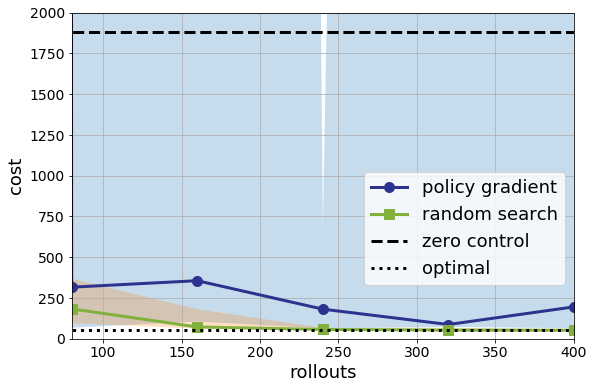

In [4]:
colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac"]
          
label_fontsize = 18
tick_fontsize = 14
linewidth = 3
markersize = 10

tot_samples = 8*np.array(N_vals)

plt.plot(tot_samples,np.median(J_finite_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_finite_pg,axis=0), np.amax(J_finite_pg,axis=0), alpha=0.25)


plt.plot(tot_samples,np.median(J_finite_rs,axis=0),'s-',color=colors[2],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_finite_rs,axis=0), np.amax(J_finite_rs,axis=0), alpha=0.25)


plt.plot([tot_samples[0],tot_samples[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.plot([tot_samples[0],tot_samples[-1]],[J_finite_opt, J_finite_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([80,400,0,2000])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

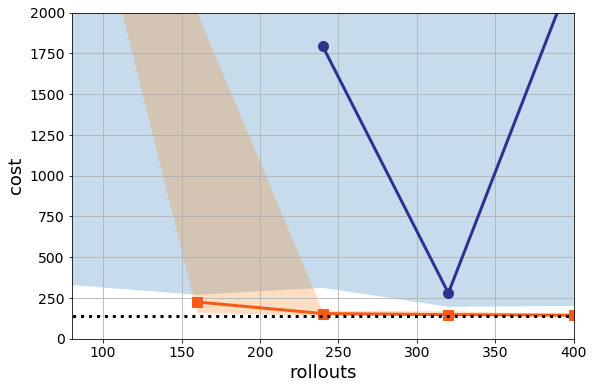

In [5]:
yclip = 2000

plt.plot(tot_samples, np.median(J_inf_pg,axis=0),'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')
plt.fill_between(tot_samples, np.amin(J_inf_pg,axis=0), np.minimum(np.amax(J_inf_pg,axis=0),yclip), alpha=0.25)

plt.plot(tot_samples,np.median(J_inf_rs,axis=0),'s-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='random search')
plt.fill_between(tot_samples, np.amin(J_inf_rs,axis=0), np.minimum(np.amax(J_inf_rs,axis=0),yclip), alpha=0.25)

plt.plot([tot_samples[0],tot_samples[-1]],[J_inf_opt, J_inf_opt],color='#000000',linewidth=linewidth,
             linestyle=':',label='optimal')

plt.axis([80,400,0,yclip])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('cost',fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

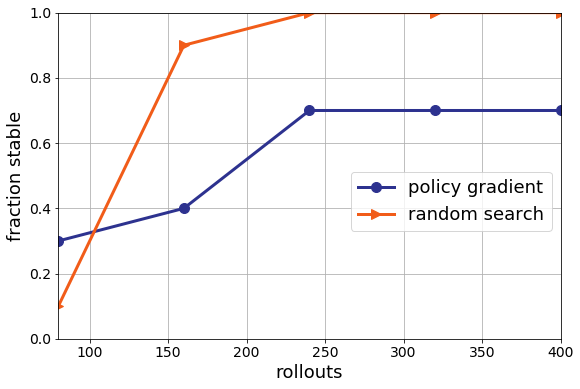

In [6]:
plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_pg),axis=0)/10,'o-',color=colors[0],linewidth=linewidth,
         markersize=markersize,label='policy gradient')

plt.plot(tot_samples,1-np.sum(np.isinf(J_inf_rs),axis=0)/10,'>-',color=colors[1],linewidth=linewidth,
         markersize=markersize,label='random search')

plt.axis([80,400,0,1])

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('fraction stable',fontsize=label_fontsize)
plt.legend(fontsize=18, bbox_to_anchor=(1.0, 0.54))

plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()

In [7]:
one_rollout_cost-J_finite_opt

46.306420715048787

In [8]:
one_rollout_cost_inf-J_inf_opt

inf

In [9]:
J_inf_opt

137.28716597811132